# ST7 Planification quotidienne d’une équipe mobile

In [37]:
# Modules de base
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Module relatif à Gurobi
from gurobipy import *

# Utilités
from datetime import datetime

## Formulation du problème

### Notation
- $ V $ : Nombre de tâches + 1 (V pour vertex)
- $ T $ : Nombre de techniciens
- $ i, j \in \{0, ..., V - 1\} $ : les indices des tâches
- $ k \in \{0, ..., T - 1 \} $ : les indices des techniciens
- $ (opening_i)_i $ : l’ouverture des sites
- $ (closing_i)_i $ : la fermeture des sites
- $ (start_k)_k $ : le début de travail des employés
- $ (end_k)_k $ : la fin de travail de chaque employé
- $ (duration_i)_i $ : la durée de chaque tâche
- $ (distance_{i, j}) $ : la distance entre les sites
- $ speed $ : la vitesse de déplacement des techniciens
- $ M $ : majorant pour notre problème



### Variables de décisions
- $ \tilde{T} $ : Le nombre de techniciens actifs (avec une tâche ou plus)
- $ (x_{i, j})_{i, j} $, $ x_{i, j} = 1 $ ssi. (i, j) est un arc de i vers j
- $ (y_{k, i})_{k, i} $, $ y_{k, i} = 1 $ ssi. le technicien k effectue la tâche i
- $ (b_i)_i $, $B_i$ est le début de chaque tâche en minute (b pour beginning)


### Objectif d’optimisation
$$ min \sum_{i, j} x_{i, j} \cdot distance_{i, j} $$


### Contraintes
- (C1) : Il n’y a qu’une seule composante connexe dans le graphe des parcours
$$ \sum_{i, j} x_{i, j} = \tilde{T} + (V - 1) $$
- (C2) Il y a autant d’arcs sortant/entrant au dépôt que de techniciens actifs
$$ \tilde{T} = \sum_i x_{0, i} = \sum_i x_{i, 0}$$
- (C3) Le site de chaque tâche est visité par exactement un technicien
$$ \forall i > 0, \sum_j x_{i, j} = \sum_j x_{j, i} = 1 $$
- (C4) Deux tâches qui se suivent doivent être faites par le même technicien
$$ \forall i, j > 0, x_{i, j} \implies \forall k, y_{k, i} = y_{k, j} \\
\Longleftrightarrow \forall i, j > 0, \forall k, y_{k, i} \le y_{k, j} + M \cdot (1 - x_{i, j}) \text{ et } y_{k, j} \le y_{k, i} + M \cdot (1 - x_{i, j}) $$
- (C5) Lorsqu’un travail est effectué sur une tâche, la tâche doit être disponible.
$$ \forall i > 0, (b_i \ge opening_i) \land (b_i + duration_i \le closing_i) $$
- (C6) La fenêtre de temps entre deux travaux doit être suffisante pour le trajet
$$ \forall i, j > 0, x_{i, j} = 1 \implies b_i + duration_i + \frac{distance_{i, j}}{speed} \le b_j \\
\Longleftrightarrow \forall i, j > 0, b_i + duration_i + \frac{distance_{i, j}}{speed} \le b_j + M \cdot (1-x_{i, j}) $$
- (C7) Un technicien doit avoir suffisamment de temps pour aller à son premier site
$$ \forall k, \forall i > 0, y_{k, i} \land x_{0, i} \implies start_k + \frac{distance_{0, i}}{speed} \le b_i \\
\Longleftrightarrow \forall k, \forall i > 0, start_k + \frac{distance_{0, i}}{speed} \le b_i + (2 - y_{k, i} - x_{0, i}) \cdot M $$
- (C8) Un technicien doit avoir suffisamment de temps pour rentrer au dépot après sa dernière tâche
$$ \forall k, \forall i > 0, y_{k, i} \land x_{i, 0} \implies b_i + duration_i + \frac{distance_{i, 0}}{speed} \le end_k \\
\Longleftrightarrow \forall k, \forall i > 0, b_i + duration_i + \frac{distance_{i, 0}}{speed} \le end_k + (2 - y_{k, i} - x_{i, 0}) \cdot M $$
- (C9) Un technicien n’effectue que des tâches qu’il est capable d’effectuer
$$ \forall k, \forall i > 0, levelTech_k \ge levelTask_i - M \cdot (1 - y_{k, i}) $$
- (C10) Une tâche est réalisée par un seul employé
$$ \forall i > 0, \sum_k y_{k, i} = 1 $$



## Variables de décisions
$ X \in R_{V + 1 \times V + 1}$

In [38]:
import pandas as pd
import numpy as np
from datetime import datetime
from math import radians, cos, sin, asin, sqrt
from utilities import parse_time_minute, parse_time


class Employee:
    list = []  # initialized to empty list
    count = 0
    speed = 50 * 1000 / 60  # unit: meter/minute

    def __init__(self, name: str, latitude: float, longitude: float, skill: str, level: int, start_time, end_time):
        self.name = name
        self.latitude = latitude
        self.longitude = longitude
        self.skill = skill
        self.level = level
        self.start_time_str = parse_time(start_time)  # parse time into datetime object for printing
        self.end_time_str = parse_time(end_time)
        self.start_time = parse_time_minute(start_time)  # parse time into minutes
        self.end_time = parse_time_minute(end_time)
        Employee.count += 1
        Employee.list.append(self)

    @classmethod
    def load_excel(cls, path):
        df_employees = pd.read_excel(path, sheet_name="Employees")
        df_employees.set_index("EmployeeName")

        for index, row in df_employees.iterrows():
            Employee(row["EmployeeName"],
                     row["Latitude"],
                     row["Longitude"],
                     row["Skill"],
                     row["Level"],
                     row["WorkingStartTime"],
                     row["WorkingEndTime"])

    def __hash__(self):
        return hash(self.name)

    def __eq__(self, other):
        return self.name == other.name

    def __str__(self):
        return self.name

    def __repr__(self):
        return f"Employee(name={self.name}, " \
               f"position=[{self.longitude}, {self.latitude}], " \
               f"skill_requirement=level {self.level} {self.skill}," \
               f"available=[{self.start_time_str.strftime('%I:%M%p')}, {self.end_time_str.strftime('%I:%M%p')}] )"


class Task:
    list = []
    count = 0
    distance: np.array = None
    __is_initialized = False

    def __init__(self, task_id, latitude, longitude, duration, skill, level, opening_time, closing_time):
        if Task.__is_initialized:
            raise Exception("Cannot instantiate new task after initializing the distance matrix")
        self.id = task_id
        self.latitude = latitude
        self.longitude = longitude
        self.duration = duration
        self.skill = skill
        self.level = level
        self.opening_time_str = parse_time(opening_time)
        self.closing_time_str = parse_time(closing_time)
        self.opening_time = parse_time_minute(opening_time)
        self.closing_time = parse_time_minute(closing_time)

        Task.list.append(self)
        Task.count += 1

    @classmethod
    def load_excel(cls, path, initialize_distance=False, load_depot=False):

        # create a dummy task at position 0 for depot
        if load_depot:
            df_employees = pd.read_excel(path, sheet_name="Employees")
            depot_longitude = df_employees.iloc[0]["Longitude"]
            depot_latitude = df_employees.iloc[0]["Latitude"]
            Task("T0", depot_latitude, depot_longitude, 0, None, 0, None, None)

        df = pd.read_excel(path, sheet_name="Tasks")
        df.set_index("TaskId")

        for index, row in df.iterrows():
            # parse the start time and end time into datetime object
            opening_time = datetime.strptime(row["OpeningTime"], '%I:%M%p')
            closing_time = datetime.strptime(row["ClosingTime"], '%I:%M%p')

            Task(row["TaskId"],
                 row["Latitude"],
                 row["Longitude"],
                 row["TaskDuration"],
                 row["Skill"],
                 row["Level"],
                 opening_time,
                 closing_time)

        if initialize_distance:
            cls.initialize_distance()

    @staticmethod
    def calculate_distance(task1, task2):
        lon1, lat1 = radians(task1.longitude), radians(task1.latitude)
        lon2, lat2 = radians(task2.longitude), radians(task2.latitude)

        # Haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
        c = 2 * asin(sqrt(a))
        r = 6371 * 1000  # radius of earth
        return c * r

    @classmethod
    def initialize_distance(cls):
        if cls.__is_initialized:
            raise Exception("Distance has already been initialized")
        cls.__is_initialized = True
        cls.distance = np.zeros((cls.count, cls.count), dtype=np.float64)

        for i in range(cls.count):
            for j in range(i):
                task_i, task_j = cls.list[i], cls.list[j]
                cls.distance[i, j] = cls.distance[j, i] = cls.calculate_distance(task_i, task_j)

    def __hash__(self):
        return hash(self.id)

    def __eq__(self, other):
        return self.id == other.id

    def __repr__(self):
        return f"Task(id={self.id}, " \
               f"position=[{self.longitude}, {self.latitude}], " \
               f"duration={self.duration}, " \
               f"skill_requirement=level {self.level} {self.skill}," \
               f"opening_time=[{self.opening_time_str.strftime('%I:%M%p')} to {self.closing_time_str.strftime('%I:%M%p')}]"


In [39]:
from file_paths import path_bordeaux

In [40]:
# reading dataframe into python objects
Employee.load_excel(path_bordeaux)
Task.load_excel(path_bordeaux, initialize_distance=True, load_depot=True)

In [41]:
V = len(Employee.list)
T = len(Task.list)

In [42]:
# test on Task object
Task.list[1]

Task(id=T1, position=[-0.3193922422375719, 44.55654938342008], duration=60, skill_requirement=level 1 Oenology,opening_time=[08:00AM to 06:00PM]

In [43]:
V = Task.count
T = Employee.count
(V, T)

(11, 2)

In [44]:
opening_time = np.array([Task.list[i].opening_time for i in range(V)])
closing_time = np.array([Task.list[i].closing_time for i in range(V)])
duration = np.array([Task.list[i].duration for i in range(V)])

M = 1000000

In [45]:
m = Model("DB")

X = {(i, j) : m.addVar(vtype = GRB.BINARY, name = f'x{i}_{j}') for i in range(V) for j in range(V) if i != j}
Y = {(k, i) : m.addVar(vtype = GRB.BINARY, name = f'y{k}_{i}') for k in range(T) for i in range(V)}
B = {i : m.addVar(vtype = GRB.CONTINUOUS, name = f'b{i}', lb = 0) for i in range(V)}
K = {k : m.addVar(vtype = GRB.BINARY, name = f'k{k}') for k in range(T)}

# C1
for k in range(T):
    m.addConstr(K[k] <= quicksum([Y[(k,i)] for i in range(1,V)]))
    for i in range(1,V):
        m.addConstr(K[k] >= Y[(k,i)])
    
m.addConstr(quicksum([X[(0,j)] for j in range(1,V)])  == quicksum([K[k] for k in range(T)]))

# C2
for i in range(1,V):
    m.addConstr(quicksum([X[(i,j)] for j in range(V) if i != j]) == quicksum([X[(j,i)] for j in range(V) if i != j]))
    
# C3
for i in range(1,V):
    m.addConstr(quicksum([X[(i,j)] for j in range(V) if i != j]) == 1)
                      
# C4
C4  = {(i,j,k) : m.addConstr(Y[(k,i)] <= Y[(k,j)] + M*(1-X[(i,j)])) for i in range(1,V) for j in range(1,V) for k in range(T) if i != j}
C4b = {(i,j,k) : m.addConstr(Y[(k,i)] >= Y[(k,j)] - M*(1-X[(i,j)])) for i in range(1,V) for j in range(1,V) for k in range(T) if i != j}

# C5
C5o = dict()
C5c = dict()
for i in range(1,V):
    C5o[i] = m.addConstr(B[i] >= opening_time[i])
    C5c[i] = m.addConstr(duration[i] + B[i] <= closing_time[i])

# C6
C6 = {(i,j) : m.addConstr(B[i] + duration[i] + Task.distance[i,j]/Employee.speed <= B[j] + M * (1-X[(i,j)]) ) for i in range(1,V) for j in range(1,V) if i != j}

# C7
C7 = {(k,i) : m.addConstr(Employee.list[k].start_time + (Task.distance[0,i]/Employee.speed) - (2 - Y[(k,i)] - X[(0,i)]) * M <= B[i]) for k in range(T) for i in range(1,V)}

# C8
C8 = {(k,i) : m.addConstr(B[i] + duration[i] + Task.distance[0,i]/Employee.speed <= Employee.list[k].end_time + M*(2-Y[(k,i)]-X[(i,0)])) for k in range(T) for i in range(1,V)}

# C9
C9 = {(k,i) : m.addConstr(Employee.list[k].level >= Task.list[i].level - M * (1 - Y[(k,i)]))  for k in range(T) for i in range(1,V)}

# C10
C10 = {i : m.addConstr(quicksum([Y[(k,i)] for k in range(T)]) == 1) for i in range(1,V)}

In [46]:
obj = quicksum([X[(i,j)]*Task.distance[i,j] for i in range(V) for j in range(V) if i != j])
m.setObjective(obj, GRB.MINIMIZE)

In [47]:
m.params.outputflag = 0

m.update()

m.optimize()

In [48]:
assert m.status != GRB.INFEASIBLE

In [49]:
print("K : {}".format([k for k in range(T) if K[k].x == 1]))

for k in range(T):
    print("Y_{} : {}".format(k,[i for i in range(1,V) if Y[(k,i)].x == 1]))
print()
for i in range(V):
    print([(i,j) for j in range(V) if i != j and X[(i,j)].x == 1])
print()
print(["B_{} : {}".format(i,B[i].x) for i in range(V)])

K : [0, 1]
Y_0 : [3, 4, 5, 6, 7, 9]
Y_1 : [1, 2, 8, 10]

[(0, 2), (0, 9)]
[(1, 8)]
[(2, 1)]
[(3, 5)]
[(4, 6)]
[(5, 0)]
[(6, 3)]
[(7, 4)]
[(8, 10)]
[(9, 7)]
[(10, 0)]

['B_0 : 0.0', 'B_1 : 633.0132710724133', 'B_2 : 511.7101160816378', 'B_3 : 804.8850328630069', 'B_4 : 666.8332214322872', 'B_5 : 879.560576787917', 'B_6 : 737.4131952231983', 'B_7 : 581.35533686704', 'B_8 : 770.5746364463116', 'B_9 : 501.7524454684455', 'B_10 : 838.3120163299599']


In [50]:
#Z associe un indice de tâche à l'employé qui l'effectue
Z = {}
for i in range(V):
    for k in range(T):
        if Y[(k,i)].x == 1:
            Z[i] = k

In [51]:
file = open("Results\SolutionPolandV1ByV1.txt","w")
file.write("taskId;performed;employeeName;startTime; \n")
for i in range(1,V):
    file.write(f"T{i};1;{Employee.list[Z[i]].name};{B[i].x};\n")
file.write("\n")
file.write("employeeName;lunchBreakStartTime;\n")
for k in range(T):
    file.write(f"{Employee.list[k].name};0;\n")
file.close()

In [52]:
max([Task.distance[i,j] for i in range(V) for j in range(V)])/Employee.speed

127.79477073284689

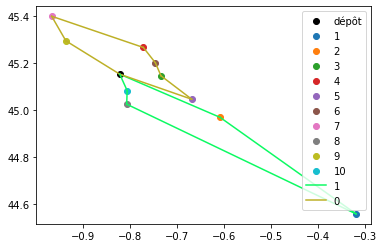

In [53]:
n_task = V

task_pos =[[Employee.list[0].longitude, Employee.list[0].latitude]]
plt.scatter([Employee.list[0].longitude], [Employee.list[0].latitude], label="dépôt", c="black")
for j in range(1,n_task):
    task_pos.append([Task.list[j].longitude, Task.list[j].latitude])
    plt.scatter([Task.list[j].longitude], [Task.list[j].latitude], label=f"{j}")

number_of_colors = 8

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]



for i in range(n_task):
    for j in range(n_task):
        if i != j and X[(i,j)].x == 1 :
            if i == 0:
                plt.plot([task_pos[i][0],task_pos[j][0]], [task_pos[i][1],task_pos[j][1]], c=color[Z[j]], label=f"{Z[j]}")
            else :
                plt.plot([task_pos[i][0],task_pos[j][0]], [task_pos[i][1],task_pos[j][1]], c=color[Z[i]])

plt.legend()
plt.show()

